In [4]:
# Project 1: Fall 2025
# Member/s: Sergey Dutt
# Coder: Sergey Dutt

import sympy as sp # all of my functions will be symbolic, mostly to take advantages of the manipulation tools within sympy, like diff for handeling partial differentials within the taylor-series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# function and loop to create derivatives 
t, y = sp.symbols('t y')

def d(f):
    d_list = {1: f} # first derivative: dy/dt = f(t, y)
    max_order = 8

    for i in range(2, max_order + 1):
        d_prev = d_list[i - 1]
        d_current = sp.diff(d_prev, t) + sp.diff(d_prev, y) * f
        d_list[i] = sp.simplify(d_current)
        
    return d_list

In [6]:
# Task 3: Replicate the Results from Tasks 1 and 2
generic = d(f = sp.Function('f')(t, y))
task_3a = d(f = t**2 + y)
task_3b = d(f = t + y**2)
print("Generically: y'' = ", generic[2])
print("Generically: y''' = ", generic[3])
print("The Second Derivative for (a) is y'' = ", task_3a[2])
print("The Second Derivative for (b) is y'' = ", task_3b[2])
print("The Third Derivative for (a) is y''' = ", task_3a[3])
print("The Third Derivative for (b) is y''' = ", task_3b[3])

Generically: y'' =  f(t, y)*Derivative(f(t, y), y) + Derivative(f(t, y), t)
Generically: y''' =  f(t, y)**2*Derivative(f(t, y), (y, 2)) + f(t, y)*Derivative(f(t, y), y)**2 + 2*f(t, y)*Derivative(f(t, y), t, y) + Derivative(f(t, y), t)*Derivative(f(t, y), y) + Derivative(f(t, y), (t, 2))
The Second Derivative for (a) is y'' =  t**2 + 2*t + y
The Second Derivative for (b) is y'' =  2*y*(t + y**2) + 1
The Third Derivative for (a) is y''' =  t**2 + 2*t + y + 2
The Third Derivative for (b) is y''' =  2*y + 2*(t + y**2)*(t + 3*y**2)


In [7]:
# function and loop to create a taylor-series approximation 
t_0, y_0, h = sp.symbols('t_0 y_0 h')

def taylor(t_0, y_0, h, order, kind):
    
    series = y_0 # first term in taylor series is y
    
    for n in range (1, order + 1): 
        
        # taylor series = previously computed series + h^(n) / n! * y^(n) (t)
        series = series + ((h**n) / (sp.factorial(n))) * kind[n].subs({t: t_0, y: y_0})
        
        symbolic = isinstance(t_0, sp.Basic) or isinstance(y_0, sp.Basic)

    if symbolic:
        # it is difficult to read the output for generic high-order Taylor polynomials, so this will show that they were created
        print(f" T{order} created") 
        return sp.simplify(series) # used for displaying the taylor series 
    else:
        return float(series) # used for numerically computing a value (when t_0 and y_0 are defined)

In [8]:
# Task 4: Generate 4th, 5th, 6th, and 8th order taylor approximation polynomials for y(t+h)
# Takes ~ 20 sec to run because it uses a generic f(t, y)
generic = d(f = sp.Function('f')(t, y))
T2 = taylor(t_0, y_0, h, order = 2, kind = generic) # added 2nd order to display 
                                                    # higher order taylor polynomials are not easy to read as output
T4 = taylor(t_0, y_0, h, order = 4, kind = generic)
T5 = taylor(t_0, y_0, h, order = 5, kind = generic)
T6 = taylor(t_0, y_0, h, order = 6, kind = generic)
T8 = taylor(t_0, y_0, h, order = 8, kind = generic)

print("T2 for y(t+h) = ", T2)

 T2 created
 T4 created


 T5 created


 T6 created


 T8 created


T2 for y(t+h) =  h**2*(f(t_0, y_0)*Derivative(f(t_0, y_0), y_0) + Derivative(f(t_0, y_0), t_0))/2 + h*f(t_0, y_0) + y_0


In [9]:
# Rk4 function
def rk4(f, t_0, y_0, h):
    
    f = sp.lambdify((t, y), f, modules=['numpy']) # needed because all f inputs will be symbolic, not defined functions
                                                  # not entirely necessary, most added to keep the code consistent (one way of defining f)
    
    k1 = f(t_0, y_0)
    k2 = f(t_0 + h/2, y_0 + (h/2 * k1))
    k3 = f(t_0 + h/2, y_0 + (h/2 * k2))
    k4 = f(t_0 + h, y_0 + (h * k3))
    
    return y_0 + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

In [10]:
# Creating a table function 

def table(f, t_0, y_0, h, t_end, numerical_methods, true_solution):
    steps = int((t_end - t_0) / h)
    t_values = [t_0]
    results = {method: [y_0] for method in numerical_methods}

    f_derivatives = d(f)

    for i in range(steps):
        t_current = t_values[-1]
        for method in numerical_methods:
            if method == 'RK4':
                y_next = rk4(f, t_current, results[method][-1], h)
            elif method.startswith('T'):
                order = int(method[1:])
                y_next = taylor(t_current, results[method][-1], h, order, f_derivatives)
            else:
                raise ValueError(f"Unknown method: {method}")
            results[method].append(y_next)
        t_values.append(t_current + h)

    # Build table (dataframe, technically)
    
    data = {'t': t_values}
    for method in numerical_methods:
        data[f'{method}_y'] = results[method]
        data[f'{method}_error'] = [
            abs(float(true_solution(t_val)) - y_val)
            for t_val, y_val in zip(t_values, results[method])
        ]

    return pd.DataFrame(data)

In [11]:
# This function makes the tables look better for the paper

def table_polisher(table, name):
    
    table_updated = table.copy()

    # all values will go to 3 decimal places 
    def format_numbers(x):
        if isinstance(x, (int, float, np.floating)):
            if abs(x) < 1e-3 or abs(x) >= 1e4:
                return f"{x:.3e}"   # scientific notation
            else:
                return f"{x:.3f}"   # fixed 3 decimal places
        return x

    # Apply format_numbers
    for col in table_updated.columns:
        table_updated[col] = table_updated[col].apply(format_numbers)

    # Create figure
    fig, ax = plt.subplots(figsize=(len(table_updated.columns) * 1.2,
                                    len(table_updated) * 0.5))
    ax.axis('off')

    # Create table with lines and centered text
    table_plot = ax.table(cellText=table_updated.values,
                          colLabels=table_updated.columns,
                          cellLoc='center',
                          loc='center')

    # borders, font size, and scaling
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(9)
    table_plot.scale(1.2, 1.2)

    # grid lines
    for _, cell in table_plot.get_celld().items():
        cell.set_linewidth(0.8)

    # Saving table
    plt.tight_layout()
    plt.savefig(f"{name}.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    print(f" Saved table as {name}.pdf")

In [12]:
# true solution solver

def ode_solver(f, t_0, y_0):
    y_symbolic = sp.Function('y')(t)
    ode = sp.Eq(y_symbolic.diff(t), f.subs(y, y_symbolic)) #lhs = dy/dt, rhs = f(t,y)
    y_true_solution = sp.dsolve(ode, y_symbolic, ics = {y_symbolic.subs(t, t_0): y_0})
    y_true_function = sp.lambdify(t, y_true_solution.rhs, modules=['numpy'])
    return(y_true_function)

In [13]:
# Task 5
# dy/dt = t^4, y(0) = 1, step size h = 0.1
# find y(1) using RK4, T4, and T5, then calculate the total error at each node

# Step 1: Compute derivatives for the given function
task_5 = d(f = t**4)

# Step 2: run that function through the numerical methods
RK4 = rk4(f = t**4, t_0 = 0 , y_0 = 1, h = 0.1)
T4 = taylor(t_0 = 0, y_0 = 1, h = 0.1, order = 4, kind = task_5)
T5 = taylor(t_0 = 0, y_0 = 1, h = 0.1, order = 5, kind = task_5)

# Step 3: List all methods used 
methods = ['RK4', 'T4', 'T5']

# step 4: Find the analytical solution to the differential equation
y_true = ode_solver(f = t**4, t_0 = 0, y_0 = 1)

# Step 5: Create table out of steps 1-4
task_5_solution = table(f = t**4, 
                        t_0 = 0, y_0 = 1, h = 0.1, t_end = 1, 
                       numerical_methods = methods, 
                       true_solution = y_true)

# Step 6: Print true value
print("y(1) = ", y_true(1))

# Step 7: Display "messy" table as output in notebook
print(task_5_solution)

# Step 8: Save polished version of the table as a .png
table_polisher(table = task_5_solution, name = "task_5_table")

y(1) =  1.2
      t     RK4_y     RK4_error     T4_y  T4_error      T5_y      T5_error
0   0.0  1.000000  0.000000e+00  1.00000  0.000000  1.000000  0.000000e+00
1   0.1  1.000002  8.333333e-08  1.00000  0.000002  1.000002  0.000000e+00
2   0.2  1.000064  1.666667e-07  1.00006  0.000004  1.000064  0.000000e+00
3   0.3  1.000486  2.500000e-07  1.00048  0.000006  1.000486  0.000000e+00
4   0.4  1.002048  3.333333e-07  1.00204  0.000008  1.002048  0.000000e+00
5   0.5  1.006250  4.166667e-07  1.00624  0.000010  1.006250  0.000000e+00
6   0.6  1.015553  5.000000e-07  1.01554  0.000012  1.015552  2.220446e-16
7   0.7  1.033615  5.833333e-07  1.03360  0.000014  1.033614  4.440892e-16
8   0.8  1.065537  6.666667e-07  1.06552  0.000016  1.065536  6.661338e-16
9   0.9  1.118099  7.500000e-07  1.11808  0.000018  1.118098  6.661338e-16
10  1.0  1.200001  8.333333e-07  1.19998  0.000020  1.200000  6.661338e-16


 Saved table as task_5_table.pdf


In [14]:
# Task 6
# dy/dt = -ty, y(1) = 1, step size h = 0.1
# find y(2) using RK4, and T4, then calculate the total error at each node

task_6 = d(f = -1*t*y)

RK4 = rk4(f = -1*t*y, t_0 = 1 , y_0 = 1, h = 0.1)
T4 = taylor(t_0 = 1, y_0 = 1, h = 0.1, order = 4, kind = task_6)

methods = ['RK4', 'T4']

y_true = ode_solver(f = -1*t*y, t_0 = 1, y_0 = 1)

task_6_solution = table(f = -1*t*y, 
                        t_0 = 1, y_0 = 1, h = 0.1, t_end = 2, 
                       numerical_methods = methods,
                       true_solution = y_true)

print("y(2) = ", y_true(2))

print(task_6_solution)

table_polisher(table = task_6_solution, name = "task_6_table")

y(2) =  0.22313016014842982
      t     RK4_y     RK4_error      T4_y      T4_error
0   1.0  1.000000  0.000000e+00  1.000000  0.000000e+00
1   1.1  0.900325  9.303873e-08  0.900325  4.774137e-07
2   1.2  0.802519  2.185893e-07  0.802520  7.615306e-07
3   1.3  0.708221  3.797566e-07  0.708221  8.625789e-07
4   1.4  0.618784  5.771532e-07  0.618784  8.046847e-07
5   1.5  0.535262  8.083934e-07  0.535262  6.219538e-07
6   1.6  0.458407  1.067905e-06  0.458406  3.540158e-07
7   1.7  0.388681  1.347105e-06  0.388680  4.158625e-08
8   1.8  0.326281  1.634932e-06  0.326280  2.774664e-07
9   1.9  0.271174  1.918678e-06  0.271172  5.711911e-07
10  2.0  0.223132  2.185018e-06  0.223129  8.155519e-07


 Saved table as task_6_table.pdf


In [20]:
# Task 7
# dy/dt = sin(5pi t) - cos(5pi t) + y(t), y(0) = 1, step size h = 0.2, solve for y(2)

f_ = sp.sin(5 * sp.pi * t) - sp.cos(5 * sp.pi * t) + y
t0_ = 0
y0_ = 1
h_ = 0.2

task_7 = d(f = f_)

RK4 = rk4(f = f_, t_0 = t0_ , y_0 = y0_, h = h_)
T4 = taylor(t_0 = t0_, y_0 = y0_, h = h_, order = 4, kind = task_7)
T6 = taylor(t_0 = t0_, y_0 = y0_, h = h_, order = 6, kind = task_7)
T8 = taylor(t_0 = t0_, y_0 = y0_, h = h_, order = 8, kind = task_7)

methods = ['RK4', 'T4', 'T6', 'T8']

y_true = ode_solver(f = f_, t_0 = t0_, y_0 = y0_)

task_7_solution = table(f = f_, 
                        t_0 = t0_, y_0 = y0_, h = h_, t_end = 2, 
                       numerical_methods = methods,
                       true_solution = y_true)

print("y(2) = ", y_true(2))

print(task_7_solution)

table_polisher(table = task_7_solution, name = "task_7_table")

y(2) =  7.768364893173161
      t     RK4_y     RK4_error      T4_y      T4_error      T6_y  \
0   0.0  1.000000  1.110223e-16  1.000000  1.110223e-16  1.000000   
1   0.2  1.361333  8.049185e-03  1.423201  6.991678e-02  1.330490   
2   0.4  1.522799  1.775599e-03  1.536497  1.547308e-02  1.515977   
3   0.6  1.999880  1.021646e-02  2.078478  8.881417e-02  1.960705   
4   0.8  2.302720  4.420958e-03  2.336852  3.855260e-02  2.285724   
5   1.0  2.952476  1.344536e-02  3.056032  1.170013e-01  2.900876   
6   1.2  3.466221  8.362116e-03  3.530837  7.297780e-02  3.434051   
7   1.4  4.373576  1.825589e-02  4.514365  1.590451e-01  4.303446   
8   1.6  5.201952  1.423379e-02  5.312044  1.243261e-01  5.147155   
9   1.8  6.493597  2.542279e-02  6.689932  2.217571e-01  6.395836   
10  2.0  7.791347  2.298161e-02  7.969282  2.009168e-01  7.702804   

        T6_error      T8_y      T8_error  
0   1.110223e-16  1.000000  1.110223e-16  
1   2.279460e-02  1.356934  3.649465e-03  
2   5.046794e-03

 Saved table as task_7_table.pdf


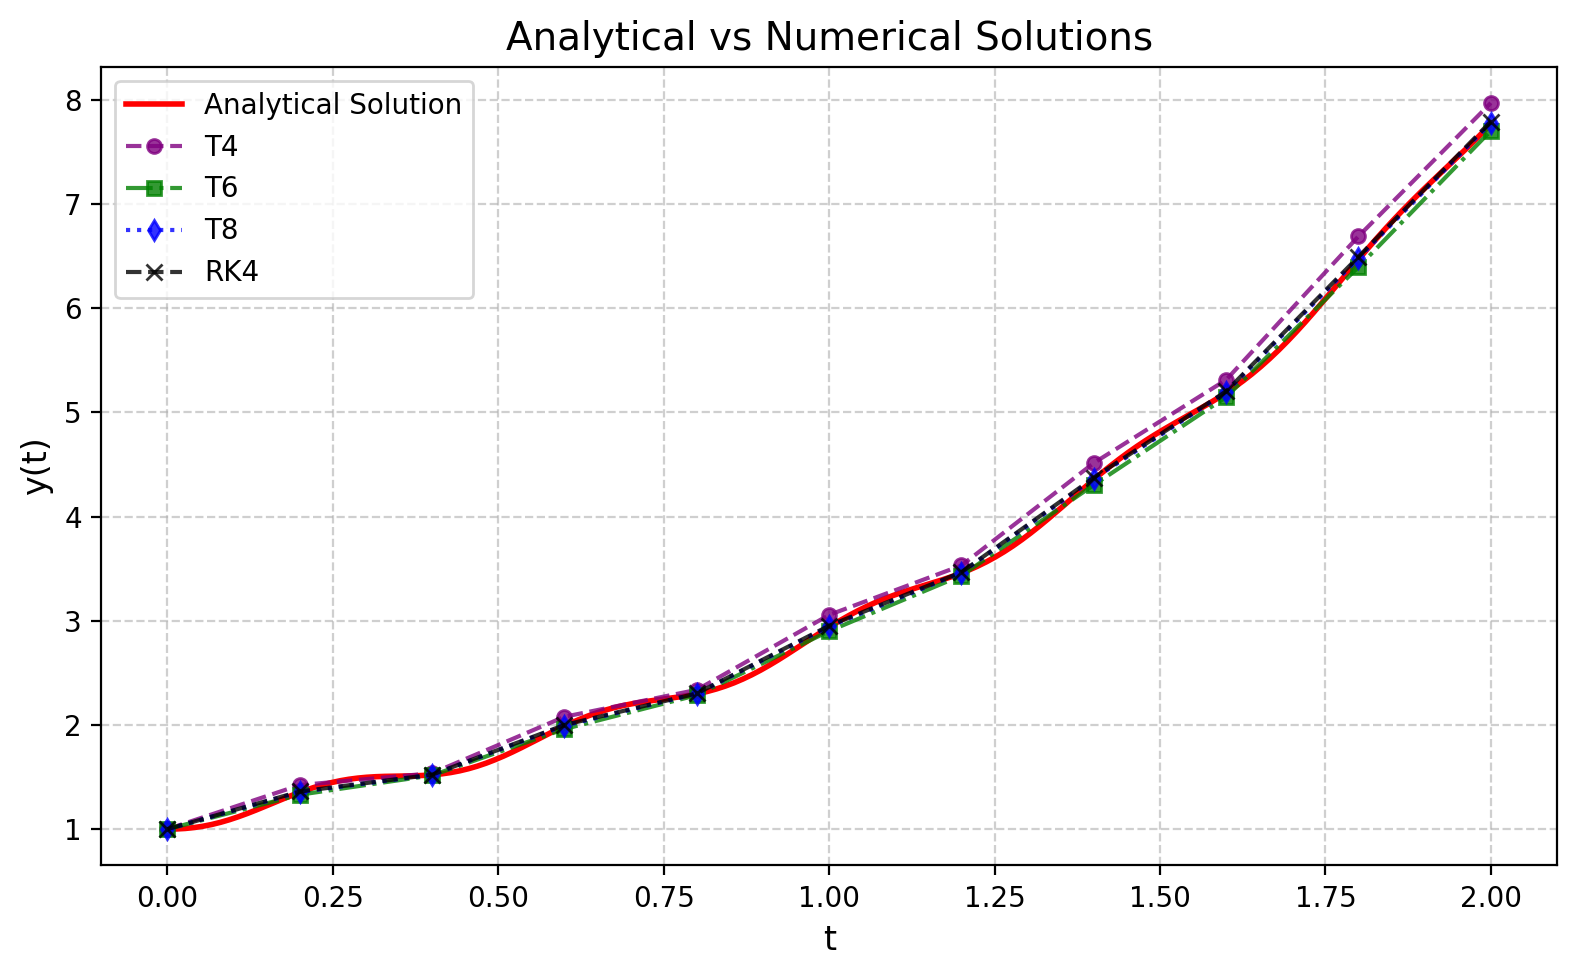

In [18]:
# Task 7 Continued
# plot the analytical solution (in red) and all numerical solutions (T4, T6, T8) on one plot

# smooth analytical solution curve
t_vals = np.linspace(0, 2, 300)
y_vals = y_true(t_vals)

# plot analytical solution
plt.figure(figsize=(8, 5))
plt.plot(t_vals, y_vals, 'r-', label='Analytical Solution', linewidth=2)

# overlay numerical methods from table
plt.plot(task_7_solution['t'], task_7_solution['T4_y'], 'o--', color='purple', label='T4', alpha=0.8, markersize=5)
plt.plot(task_7_solution['t'], task_7_solution['T6_y'], 's-.', color='green', label='T6', alpha=0.8, markersize=5)
plt.plot(task_7_solution['t'], task_7_solution['T8_y'], 'd:', color='blue', label='T8', alpha=0.8, markersize=5)
plt.plot(task_7_solution['t'], task_7_solution['RK4_y'], 'x--', color='black', label='RK4', alpha=0.8, markersize=6)

# formatting 
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.title('Analytical vs Numerical Solutions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.savefig('task7_solutions.pdf', format='pdf', dpi=300)

plt.show()

In [0]:
# bibleography: (aka, where I went to understand new code) 
# https://docs.sympy.org/latest/tutorials/intro-tutorial/calculus.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.table.html
# https://scipy-lectures.org/packages/sympy.html